In [1]:
!pip install mlc-ai-nightly -f https://mlc.ai/wheels

Looking in links: https://mlc.ai/wheels
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.6/185.6 MB 6.7 MB/s eta 0:00:00


In [2]:
!lscpu

Architecture:                x86_64
  CPU op-mode(s):            32-bit, 64-bit
  Address sizes:             46 bits physical, 48 bits virtual
  Byte Order:                Little Endian
CPU(s):                      2
  On-line CPU(s) list:       0,1
Vendor ID:                   GenuineIntel
  Model name:                Intel(R) Xeon(R) CPU @ 2.20GHz
    CPU family:              6
    Model:                   79
    Thread(s) per core:      2
    Core(s) per socket:      1
    Socket(s):               1
    Stepping:                0
    BogoMIPS:                4399.99
    Flags:                   fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pg
                             e mca cmov pat pse36 clflush mmx fxsr sse sse2 ss h
                             t syscall nx pdpe1gb rdtscp lm constant_tsc rep_goo
                             d nopl xtopology nonstop_tsc cpuid tsc_known_freq p
                             ni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2ap
                   

In [3]:
import numpy as np
import time
import tvm
from tvm import te, topi
import matplotlib.pyplot as plt

results = {}

In [4]:
# Parameters for conv2d layer
batch_size = 1
in_channels = 128
out_channels = 128
in_height, in_width = 28, 28
kernel_height, kernel_width = 3, 3
strides = (1, 1)
padding = (1, 1)
dtype = "float32"

# Calculate output shape
output_shape = (batch_size, out_channels, in_height, in_width)

# Create random input data and kernels
data_shape = (batch_size, in_channels, in_height, in_width)
kernel_shape = (out_channels, in_channels, kernel_height, kernel_width)
data_np = np.random.uniform(-1, 1, data_shape).astype(dtype)
kernel_np = np.random.uniform(-1, 1, kernel_shape).astype(dtype)

# Define the operator using TVM's Tensor Expression (TE) and TOPI
data = te.placeholder(data_shape, name="data", dtype=dtype)
kernel = te.placeholder(kernel_shape, name="kernel", dtype=dtype)
conv = topi.nn.conv2d_nchw(data, kernel, strides, padding, dilation=1, out_dtype=dtype)


In [7]:
def evaluate_schedule(schedule, tensors_to_build, description):
    """Compiles, benchmarks, and stores the result of a given schedule."""
    print(f"Evaluating: {description}...")
    target = "llvm"  # Target for CPU compilation
    func = tvm.build(schedule, tensors_to_build, target=target)

    # Set up the device and TVM arrays
    dev = tvm.cpu(0)
    data_tvm = tvm.nd.array(data_np, device=dev)
    kernel_tvm = tvm.nd.array(kernel_np, device=dev)
    output_tvm = tvm.nd.empty(output_shape, dtype, dev)

    # Measure performance (warm-up runs are handled by time_evaluator)
    # The evaluator runs the function `number` times and repeats this `repeat` times,
    # then returns the best average.
    evaluator = func.time_evaluator(func.entry_name, dev, number=20, repeat=5)
    mean_time = evaluator(data_tvm, kernel_tvm, output_tvm).mean

    results[description] = mean_time
    print(f"-> Latency: {mean_time * 1000:.4f} ms")
    print("-" * 60)
    return mean_time

In [8]:
# --- Experiment 0: Baseline (Default Schedule) ---
s_baseline = te.create_schedule(conv.op)
evaluate_schedule(s_baseline, [data, kernel, conv], "Baseline")

# --- Experiment 1: Parallelization Only ---
s_parallel = te.create_schedule(conv.op)
_, oc, _, _ = s_parallel[conv.op].op.axis
s_parallel[conv.op].parallel(oc)
evaluate_schedule(s_parallel, [data, kernel, conv], "Parallel Only")

# --- Experiment 2: Vectorization Only ---
s_vectorize = te.create_schedule(conv.op)
_, _, _, ow = s_vectorize[conv.op].op.axis
vector_width = 8 # Based on modern CPU capabilities (e.g., AVX)
wo, wi = s_vectorize[conv.op].split(ow, factor=vector_width)
s_vectorize[conv.op].vectorize(wi)
evaluate_schedule(s_vectorize, [data, kernel, conv], "Vectorize Only")

# --- Experiment 3: Tiling & Reordering Only ---
s_tiling = te.create_schedule(conv.op)
n, oc, oh, ow = s_tiling[conv.op].op.axis
ic, kh, kw = s_tiling[conv.op].op.reduce_axis
tile_oc, tile_ow = 8, 8
oco, oci = s_tiling[conv.op].split(oc, factor=tile_oc)
owo, owi = s_tiling[conv.op].split(ow, factor=tile_ow)
s_tiling[conv.op].reorder(n, oco, oh, owo, oci, ic, kh, kw, owi)
evaluate_schedule(s_tiling, [data, kernel, conv], "Tiling Only")

# # --- Experiment 4: Tiling + Parallelization ---
# s_tile_para = te.create_schedule(conv.op)
# _, oc, _, _ = s_tile_para[conv.op].op.axis
# tile_oc = 8
# oco, _ = s_tile_para[conv.op].split(oc, factor=tile_oc)
# s_tile_para[conv.op].parallel(oco) # Parallelize the outer loop
# evaluate_schedule(s_tile_para, [data, kernel, conv], "Tiling + Parallel")

# # --- Experiment 5: Tiling + Vectorization ---
# s_tile_vec = te.create_schedule(conv.op)
# _, _, _, ow = s_tile_vec[conv.op].op.axis
# vector_width = 8
# tile_ow = 8
# _, owi = s_tile_vec[conv.op].split(ow, factor=tile_ow)
# s_tile_vec[conv.op].vectorize(owi) # Vectorize the inner loop
# evaluate_schedule(s_tile_vec, [data, kernel, conv], "Tiling + Vectorize")

# --- Experiment 6: All Combined ---
s_full = te.create_schedule(conv.op)
n, oc, oh, ow = s_full[conv.op].op.axis
ic, kh, kw = s_full[conv.op].op.reduce_axis
tile_oc, tile_ow, tile_ic = 8, 8, 4
vector_width = 8
oco, oci = s_full[conv.op].split(oc, factor=tile_oc)
owo, owi = s_full[conv.op].split(ow, factor=tile_ow)
ico, ici = s_full[conv.op].split(ic, factor=tile_ic)
s_full[conv.op].reorder(n, oco, oh, owo, ico, kh, kw, oci, owi, ici)
s_full[conv.op].parallel(oco)
s_full[conv.op].vectorize(owi)
evaluate_schedule(s_full, [data, kernel, conv], "All Combined")

Evaluating: Baseline...
-> Latency: 178.9385 ms
------------------------------------------------------------
Evaluating: Parallel Only...
-> Latency: 182.0170 ms
------------------------------------------------------------
Evaluating: Vectorize Only...
-> Latency: 54.0318 ms
------------------------------------------------------------
Evaluating: Tiling Only...
-> Latency: 56.8013 ms
------------------------------------------------------------
Evaluating: All Combined...
-> Latency: 28.2433 ms
------------------------------------------------------------


np.float64(0.028243349499999997)

/tmp/ipython-input-2905881206.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(filtered_methods, rotation=35, ha="right", fontsize=12)


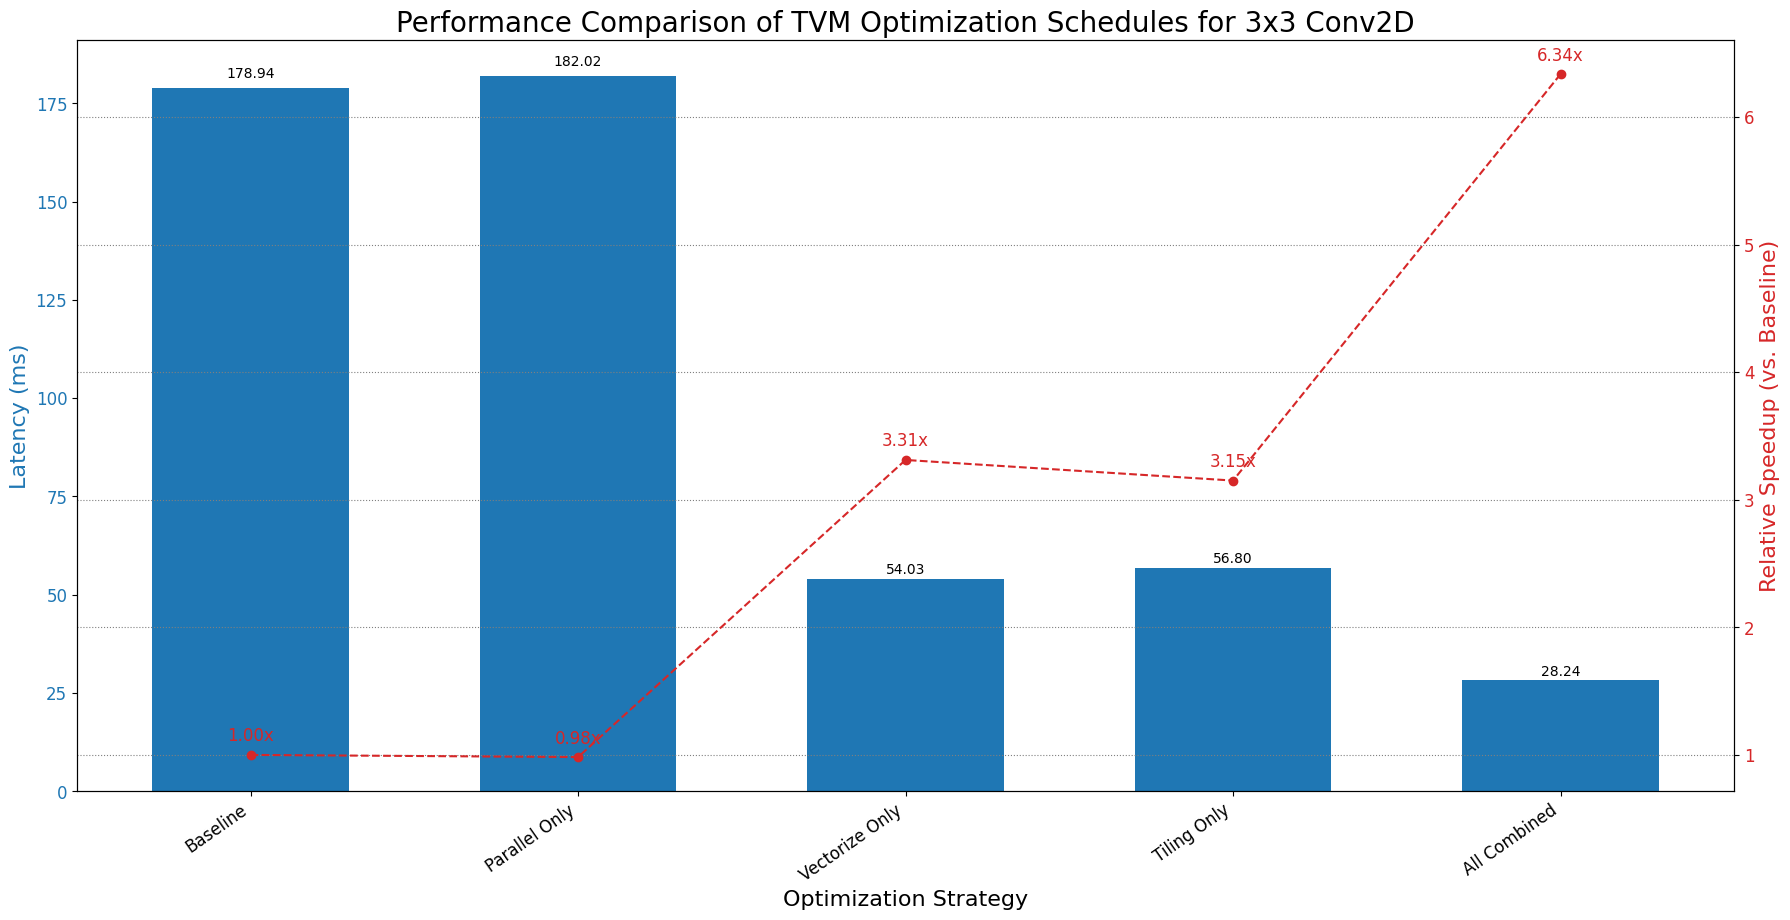

In [9]:
# Define a logical order for the plot to tell a clear story
ordered_methods = [
    "Baseline",
    "Parallel Only",
    "Vectorize Only",
    "Tiling Only",
    # "Tiling + Parallel",
    # "Tiling + Vectorize",
    "All Combined"
]

# Filter out any methods that might not have run, and prepare data
filtered_methods = [m for m in ordered_methods if m in results]
latencies = [results[method] * 1000 for method in filtered_methods] # Convert to ms
speedups = [results["Baseline"] / results[method] for method in filtered_methods]

# Create the plot
fig, ax1 = plt.subplots(figsize=(18, 9))

# Plot bars for Latency
color = 'tab:blue'
ax1.set_ylabel('Latency (ms)', color=color, fontsize=16)
bars = ax1.bar(filtered_methods, latencies, color=color, width=0.6)
ax1.tick_params(axis='y', labelcolor=color, labelsize=12)
ax1.set_xticklabels(filtered_methods, rotation=35, ha="right", fontsize=12)
ax1.set_xlabel('Optimization Strategy', fontsize=16)

# Add latency values on top of each bar
for bar in bars:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2.0, yval * 1.01, f'{yval:.2f}', ha='center', va='bottom')

# Create a second y-axis for Speedup
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Relative Speedup (vs. Baseline)', color=color, fontsize=16)
ax2.plot(filtered_methods, speedups, color=color, marker='o', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color, labelsize=12)
ax2.grid(axis='y', linestyle=':', color='gray')

# Add speedup values on the plot line
for i, txt in enumerate(speedups):
    ax2.annotate(f'{txt:.2f}x', (filtered_methods[i], speedups[i]), textcoords="offset points", xytext=(0,10), ha='center', color=color, fontsize=12)

fig.tight_layout()
plt.title('Performance Comparison of TVM Optimization Schedules for 3x3 Conv2D', fontsize=20)
plt.show()